# Introduction to DRED dataset
The goal of this notebook is to present the dataset which is used to find opportunities for efficient appliance use. This dataset is the measured energy consumption of a household in the Netherlands. The data was collected over a period of 6 months, from the 5th of July to the 5th of December in 2015. The dataset includes:
* **Electricity monitoring** - aggregated energy consumption and appliance level energy consumption.
* **Ambient information** - room-level indoor temperature, outdoor temperature, environmental parameters (wind speed, humidity, precipitation).
* **Occupancy information** - room-level location information of occupants, WiFi and BT RSSI information for localization
* **Household information** -  house layout, number of appliance monitored, appliance-location mapping, etc. 


In [47]:
# Prevent some useless warnings
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

# Import the used libraries
from dateutil import parser
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from nilmtk import DataSet
from nilmtk.utils import print_dict

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 6)

# Open the dataset
dred = DataSet('data/DRED.h5')

Populating the interactive namespace from numpy and matplotlib


## Overview
Lets get an overview of the dataset as starting point.

In [2]:
print_dict(dred.metadata)

The name of our dataset is `DRED` and contains the apparent power over a timeframe that starts on 05-7-2015 and ends on 05-12-2015. The sample periode is 1 second. So the power is measured every second.

In [3]:
# All the buildings in the dataset
dred.buildings

OrderedDict([(1, Building(instance=1, dataset='DRED'))])

As you can see, there is only one building in the dataset. The instance of this building is 1. We can use `dred.buildings[0]` to explore this building.

In [4]:
elec = dred.buildings[1].elec
elec.appliances

[Appliance(type='fridge', instance=1),
 Appliance(type='unknown', instance=1),
 Appliance(type='washing machine', instance=1),
 Appliance(type='cooker', instance=1),
 Appliance(type='fan', instance=1),
 Appliance(type='television', instance=1),
 Appliance(type='sockets', instance=1),
 Appliance(type='microwave', instance=1),
 Appliance(type='toaster', instance=1),
 Appliance(type='laptop computer', instance=1),
 Appliance(type='oven', instance=1),
 Appliance(type='electric heating element', instance=1)]

We have 13 different measured appliances in the house:
- Television
- Fan
- Fridge
- Laptop computer
- Electric heating element
- Oven
- Unknown (socket output)
- Washing machine
- Microwave
- Toaster
- Sockets
- Cooker

![Layout house](http://www.st.ewi.tudelft.nl/~akshay/dred/img/pdf/layout.png)

We can see the devices on the provided layout of the apartment

### Data consistency

In [5]:
# Get the dropout rate of every device
elec.dropout_rate()

Calculating dropout_rate for ElecMeterID(instance=13, building=1, dataset='DRED') ...   

0.0

Good news! We have a dropout rate of `0.0%`. It means there are no black spots in the data.

### Some characteristics
Okay, time to find some characteristics

#### Total energy usage

In [6]:
# Total energy
total_energy = elec.mains().total_energy()
date_start = parser.parse(dred.metadata['timeframe']['start'])
date_end = parser.parse(dred.metadata['timeframe']['end'])
delta = date_end - date_start
print("Measured total energy: {}kWh in {} days".format(total_energy['apparent'], delta.days))

# Raw total energy in a year
total_year = (365 - 0) * (total_energy - 0) / (153 - 0) + 0
print("Raw calculation total energy in a year: {}kWh in {} days".format(total_year['apparent'], 365))

Measured total energy: 407.901742778kWh in 153 days
Raw calculation total energy in a year: 973.098928849kWh in 365 days


The average energy consumption in a year of a household in the Netherlands is 2910 kWh.

#### Standard deviation

In [7]:
data = elec.mains().load().next()
data.describe()

,power
,apparent
count,1.326599e+07
mean,1.106925e+02
std,1.466472e+02
min,1.900000e+01
25%,3.500000e+01
50%,8.388000e+01
75%,1.354000e+02
max,3.744000e+03


The maximum power used in a hour of a device is $3.744*10^3W$. The standard deviation of the data is $1.466*10^2W$, which means there is a lot of fluctuation in the total energy consumption. The average energy consumption is $1.106*10^2W$.

#### Top 5 energy consumers

In [8]:
elec.select_top_k(k=5).label()

13/13 ElecMeter(instance=13, building=1, dataset='DRED', appliances=[Appliance(type='cooker', instance=1)]))])1)])ance=1)])

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/nilmtk/metergroup.py:1301: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  top_k_series.sort(ascending=asc)


'Laptop computer, Site meter, Electric heating element, Fridge, Cooker'

### Visualisation of energy usage

In [43]:
#elec['fridge'].load().next().resample('H').mean().plot(ax=ax, kind='area', stacked=True)
#elec['fan'].load().next().resample('H').mean().plot(ax=ax, kind='bar', stacked=True)

lists = []
legend_list = []

for meter in elec.meters:
    legend_list.append(meter.label())
    meter_data = meter.load().next().resample('D').mean()
    lists.append(meter_data)

format_data = pd.concat(lists, axis=1)

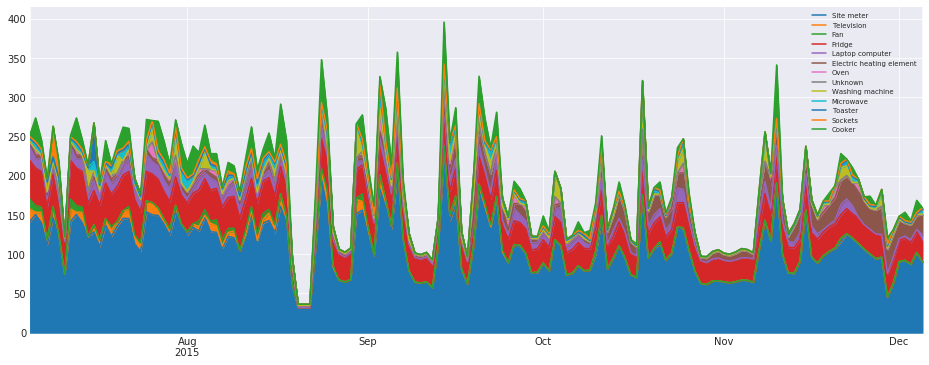

In [59]:
fig, ax = plt.subplots()
format_data.plot(ax=ax, kind='area', stacked=True)
leg = ax.legend(legend_list, loc=1, fontsize='x-small', fancybox=True)